In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

# Load dataset
data = pd.read_csv(r'C:\Users\sbath\OneDrive\Documents\Reviews.csv')
data = data[['Text', 'Score']].dropna()
data = data.sample(n=2500, random_state=42).reset_index(drop=True)
data['label'] = data['Score'].apply(lambda x: 1 if x >= 3 else 0)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Text'], data['label'], test_size=0.2, random_state=42
)

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length)
        self.labels = list(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Prepare datasets and loaders
train_dataset = ReviewDataset(train_texts, train_labels, tokenizer)
test_dataset = ReviewDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps
)

# Training loop
model.train()
for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

print(classification_report(all_labels, all_preds))



c:\Users\sbath\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sbath\anaconda3\envs\myenv\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 1920] The file cannot be accessed by the system'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model o

              precision    recall  f1-score   support

           0       0.67      0.79      0.72        66
           1       0.97      0.94      0.95       434

    accuracy                           0.92       500
   macro avg       0.82      0.86      0.84       500
weighted avg       0.93      0.92      0.92       500



In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load dataset
data = pd.read_csv(r'C:\Users\sbath\OneDrive\Documents\Reviews.csv')
data = data[['Text', 'Score']].dropna()
data = data.sample(n=2500, random_state=42).reset_index(drop=True)

# Convert ratings to binary labels (>=3 is positive)
data['label'] = data['Score'].apply(lambda x: 1 if x >= 3 else 0)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data['Text'], data['label'], test_size=0.2, random_state=42
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train traditional classifier (Logistic Regression)
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_tfidf)
print("=== Traditional Classifier (TF-IDF + Logistic Regression) ===")
print(classification_report(y_test, y_pred))


=== Traditional Classifier (TF-IDF + Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.87      1.00      0.93       434

    accuracy                           0.87       500
   macro avg       0.43      0.50      0.46       500
weighted avg       0.75      0.87      0.81       500



c:\Users\sbath\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sbath\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sbath\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# For traditional classifier
precision_trad = precision_score(y_test, y_pred)
recall_trad = recall_score(y_test, y_pred)
f1_trad = f1_score(y_test, y_pred)
accuracy_trad = accuracy_score(y_test, y_pred)

# For BERT (you already have predictions from earlier)
precision_bert = precision_score(test_labels,all_preds)
recall_bert = recall_score(test_labels, all_preds)
f1_bert = f1_score(test_labels, all_preds)
accuracy_bert = accuracy_score(test_labels,all_preds)


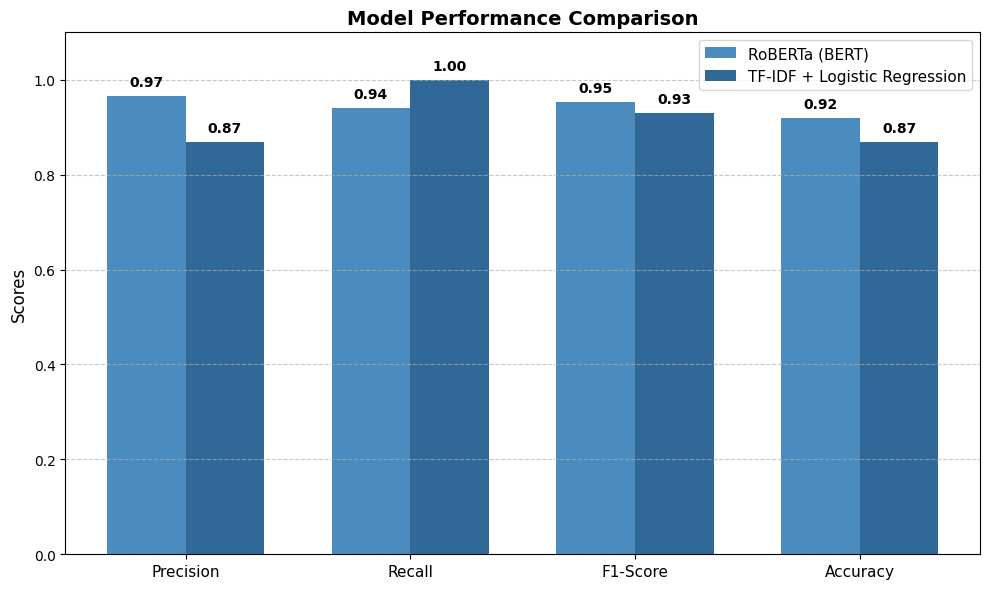

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
bert_scores = [precision_bert, recall_bert, f1_bert, accuracy_bert]
trad_scores = [precision_trad, recall_trad, f1_trad, accuracy_trad]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, bert_scores, width, label='RoBERTa (BERT)', color='#4B8BBE')
rects2 = ax.bar(x + width/2, trad_scores, width, label='TF-IDF + Logistic Regression', color='#306998')

# Labels and title
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add bar annotations
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # space above bar
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


In [4]:
import sys
print(sys.executable)


c:\Users\sbath\anaconda3\envs\myenv\python.exe
